## Исследование уровня депрессивности песни через ее текст##

Недавно в интернете было опубликовано исследование, в котором была проведена попытка анализа содержания музыкальных композиций с помощью анализа их текстов (http://blog.revolutionanalytics.com/2017/02/finding-radioheads-most-depressing-song-with-r.html). В частности, в том исследовании была найдена самая депрессивная песня группы Radiohead. Сделано это было следующим образом: для каждой песни был вычислен так называемый *Gloom Index*, рассчитываемый следуюзим образом:

$$gloomIndex = \frac{1-valence}{2}+\frac{pctSad\left(1+lyricalDensity\right)}{2},$$

где:

* **valence** - автоматически рассчитываемый индекс с сервиса Spotify, принимающий значения в диапазоне от 0 до 1 и характеризующий уровень позитивности композиции (1 - максимальный, 0 - минимальный). Соответственно, $1-valence$ характеризует степень депрессивности трека.

* **pctSad** - основная отличительная черта исследования. Существует датасет, носящий имя *NRC Word-Emotion Association Lexicon*, в котором более чем 14 тысяч слов размечены в соответствии с эмоцией, которая свойственна сущности, описываемой данным словом. Всего эмоций 8: гнев, предчувствие (anticipation), отвращение, страх, радость, грусть, удивление, доверие, а также две глобальные (положительная и негативная). Этот датасет был размечен при помощи краудсорсинга (почитать про это можно по ссылке https://arxiv.org/pdf/1308.6297.pdf). Величина **pctSad** равна проценту слов в тексте песни, вызывающих негативные ассоциации по мнению этого датасета.

* **lyricalDensity** - количество слов в секунду. В комбинации с предыдущим признаком, если в двух песнях одинаковый процент слов с негативным окрасом, то более депрессивной считается та, у которой больше **lyricalDensity**. 

Попытка повторить опыт показала, что во многих случаях **valence** не вполне адекватно отражает то, что должен отражать (все-таки, он рассчитывается автоматически при помощи методов машинного обучения), да и идея о том, что чем больше поток грустных слов, тем грустнее песня, тоже сомнительна, так что в качестве показателя депрессивности я решил просто рассматривать **pctSad**:

$$gloomIndex =pctSad$$

При таком методе анализа композиций мы будем исключать любую информацию об их звучании (так как, например, при вычислении **valence** машина "прослушивала" песни).

В своем исследовании я не буду заниматься такими вещами, как поиском наиболее депрессивной песни конкретного исполнителя. Мне интересно исследовать значение индекса депрессивности и влияние на него текстов в более масштабном смысле, например, на дистанции нескольких альбомов или в зависимости от музыкальных жанров композиций.

In [505]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords, wordnet
from string import punctuation
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import seaborn as sns
import numpy as np

stopwords=['im', 'dont', 'verse', 'chorus', 'youre', 'cant', 'ill']

Из-за коммерческих лицензий датасетов с текстами песен не существует, так что придется парсить сайт с текстами песен. Наиболее хорошо для этого подходит ***Genius*** (http://genius.com/):

In [2]:
#По ссылке на страницу с альбомом возвращает ссылки на тексты каждой из песен
def get_album_songs(url):
    raw_html = requests.get(url).text
    
    bs = BeautifulSoup(raw_html)
    album_name = bs.find_all('h1', {'class':'album_name'})[0].text.replace('\n', ' ').strip()
    
    song_parts =raw_html.split('<span class="track_number">')[1:]
    songs = []
    for part in song_parts:
        bs = BeautifulSoup(part)
        href = bs.find_all('a')[0]['href']
        title = bs.find_all('span', {'class':'song_title'})[0].text
        songs.append([album_name, title.lower(), href])
    return songs
    
#Извлекает текст песни со страницы песни
def get_song_lyrics(url):
    raw_html = requests.get(url).text
    bs = BeautifulSoup(raw_html)
    lyrics = bs.find_all('lyrics')[0].text
    lyrics = lyrics.replace('\n', ' ').strip()
    sleep(0.3)
    return lyrics

Для начала посмотрим, способен ли индекс депрессивности определить изменение в общем эмоциональном окрасе композиций на дистанции нескольких альбомов. Приведу пример (в качестве исследуемых я бы хотел брать более известных исполнителей, однако в силу не самого широкого кругозора в сфере музыки и показательности споследующего примера остановлюсь на нем):

Проанализируем 4 последних альбома британской группы *Architects*. Я остановился на этом выборе, так как в 2014 году, во время записи предпоследнего альбома, гитарист и автор всех текстов узнал, что неизлечимо болен. Это оказывает влияние на лирику альбома - поднимаются темы беспомощности перед судьбой, страха. Последний альбом пишется после получения известия о том, что болезнь почти победила, и заключительный в жизни автора альбом становится еще мрачнее. Исследуем, является ли это ощущение возросшей депрессивности субъективным, или же его можно отобразить с помощью нашего индекса:

In [3]:
#Передаем ссылки на альбомы, которые подвергнем анализу, и ждем, пока информация о песнях не появится в массиве result

album_urls = ['https://genius.com/albums/Architects/The-here-and-now', 'https://genius.com/albums/Architects/Daybreaker',
             'https://genius.com/albums/Architects/Lost-forever-lost-together',
             'https://genius.com/albums/Architects/All-our-gods-have-abandoned-us']
result = []
for url in album_urls:
    result += get_album_songs(url)

for song in tqdm(result):
    song[2] = get_song_lyrics(song[2])

100%|██████████| 51/51 [00:51<00:00,  1.11it/s]


Проведем лемматизацию слов:

In [4]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

exclude = set(punctuation + u'0123456789[]—«»–')
lmtzr = WordNetLemmatizer()
for j, song in enumerate(result):
    song[2] = ''.join(ch for ch in song[2] if ch not in exclude)
    song[2] = WhitespaceTokenizer().tokenize(song[2].lower())
    words = []
    for i, t in enumerate(song[2]):
        if t not in stopwords.words('english'):
            try:
                song[2][i] = lmtzr.lemmatize(t, get_wordnet_pos(pos_tag([t])[0][1]))
            except:
                pass
            words.append(song[2][i])
    result[j][2] = words

Теперь можно перейти к анализу текстов. Для начала загрузим *NRC Word-Emotion Association Lexicon* (размеченный по ассоциируемым со словов эмоциям словарь):

In [5]:
dic = pd.read_csv('NRC-english.csv')[['English Word', 'Positive', 'Negative', 'Anger', 'Anticipation', 
                                      'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']]

Пример эмоций для конкретного слова:

In [323]:
dic[dic['English Word'].isin(['gift', 'cheat', 'beer', 'loath'])]

,English Word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1150,beer,1,0,0,0,0,0,1,0,0,0
2021,cheat,0,1,1,0,1,0,0,0,0,0
5439,gift,1,0,0,1,0,0,1,0,1,0
7430,loath,0,1,1,0,0,0,0,0,0,0


Вычислим gloom_ind - процент слов, имеющих негативный окрас, от всех размеченных слов из песни

In [8]:
def calc_gloom_ind(lyrics):
    total = 0
    negative = 0
    for word in lyrics:
        if word in dic['English Word'].values:
            negative += ((dic[dic['English Word'] == word]['Negative']).values[0] == 1).astype(int)
            total += 1
    return negative / (total+1)

In [9]:
for i, song in enumerate(result):
    result[i].append(calc_gloom_ind(song[2]))

In [15]:
df = pd.DataFrame(result, columns = ['album', 'title', 'lyrics', 'gloom_ind'])

Визуализируем полученный результат:

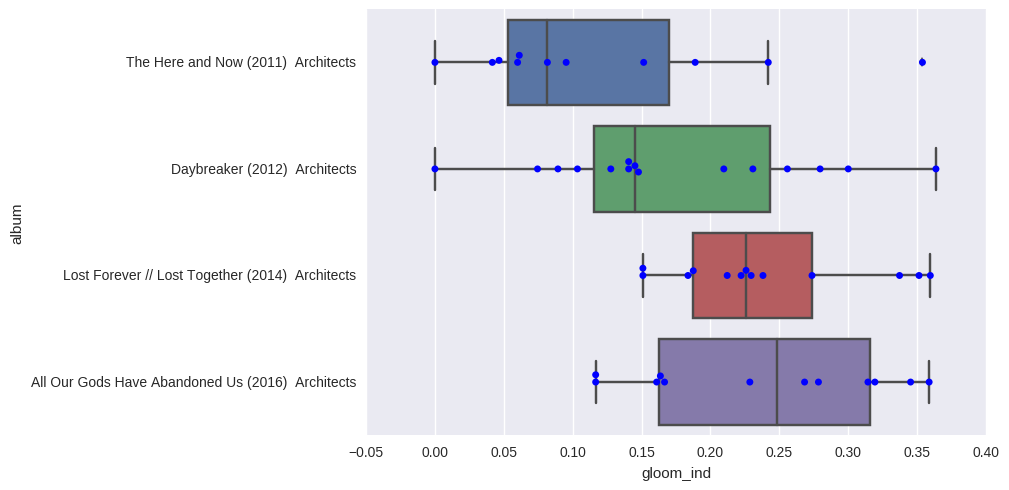

In [16]:
sns.boxplot(x='gloom_ind', y='album', data=df)
sns.swarmplot(x='gloom_ind', y='album', data=df, color='b')

Видим резкий прирост на двух последних альбомах по сравнению с предыдущими. Таким образом, исходная гипотеза о возможности визуализации описанных изменений подтверждается.

Можно попытаться сравнить *gloom index* по всему творчеству в зависимости от исполнителя. Для этой и прочих целей я создал небольшой датасет, содержащий иформацию о 7325 песнях, написанных 109 исполнителями, в шести разных жанрах (для человеческого восприятия достаточно сильно отличных друг от друга):

* Pop music
* Pop-punk/punk-rock music
* Rap
* Classic rock
* Deathcore (тяжелая музыка, ожидается наиболее высокий gloom index)
* Grunge

Изначально я определился с жанрами, а далее выкачал тексты песен 15-20 исполнителей из топа Last.fm по этому жанру. 

Загрузим его:

In [17]:
df = pd.read_csv('lyrics/data.csv')

#Удалим песни без слов
df = df[pd.notnull(df['lyrics'])]

In [18]:
df.head()

,artist,album,song,lyrics,genre
0,Eminem,The Marshall Mathers LP 2 (2013) Eminem,bad guy,[Part 1: Produced by S1 and M-Phazes][Verse 1]...,rap
1,Eminem,The Marshall Mathers LP 2 (2013) Eminem,parking lot (skit),[Teller] Don't kill me! [Eminem] Hurry the fu...,rap
2,Eminem,The Marshall Mathers LP 2 (2013) Eminem,rhyme or reason,[Intro] (What's your name?) Marshall (Who's yo...,rap
3,Eminem,The Marshall Mathers LP 2 (2013) Eminem,so much better,[Intro] You fucking groupie Pick up the goddam...,rap
4,Eminem,The Marshall Mathers LP 2 (2013) Eminem,survival,[Hook: Liz Rodrigues] This is survival of the ...,rap


Нормализуем слова в текстах и вычислим gloom_ind:

In [19]:
lyrics = df['lyrics'].values

for j, song in tqdm(enumerate(lyrics)):
    song = ''.join(ch for ch in song if ch not in exclude)
    song = WhitespaceTokenizer().tokenize(song.lower())
    words = []
    for i, t in enumerate(song):
        if t not in stopwords.words('english'):
            try:
                song[i] = lmtzr.lemmatize(t, get_wordnet_pos(pos_tag([t])[0][1]))
            except:
                pass
            words.append(song[i])
    lyrics[j] = words

7255it [09:13, 13.11it/s]


In [24]:
gloom_inds = []
for song in tqdm(lyrics):
    gloom_inds.append(calc_gloom_ind(song))

100%|██████████| 7255/7255 [24:52<00:00,  4.65it/s]


In [25]:
df['gloom_ind'] = gloom_inds

Для начала посмотрим, отличаются ли средние значения индекса в зависимости от жанра:

In [57]:
gloom_by_genre = df.groupby('genre')['gloom_ind'].mean().values
genre = df.groupby('genre')['gloom_ind'].mean().keys()

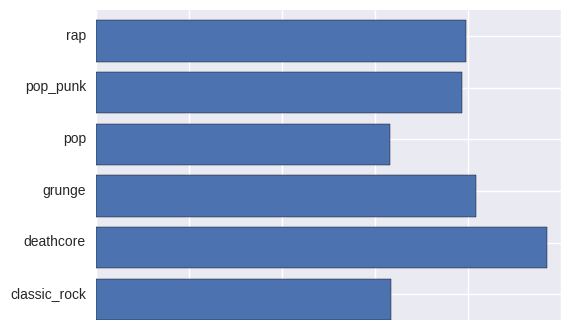

In [63]:
plt.barh(np.arange(6), gloom_by_genre)
ticks = plt.yticks(np.arange(6) + .5, genre)
xt = plt.xticks()[0]
_ = plt.xticks(xt, [' '] * len(xt))

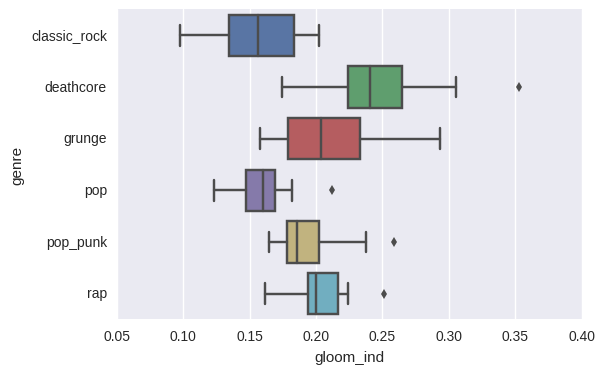

In [386]:
df_group_by_albums = df.groupby(['genre', 'artist'])['gloom_ind'].mean().reset_index()
sns.boxplot(x='gloom_ind', y='genre', data=df_group_by_albums)

Ожидаемо, deathcore на первом месте. Поп-музыка, в которой преобладают тексты про любовь и прочие радости жизни, ожидаемо оказалась одной из наименее депрессивных.

Итак, в текстах песен в зависимости от жанров присутствуют некоторые различия. Интересно попробовать обучить классификатор, определяющий жанр песни в зависимости от ее текста. На соревновании мы обучали классификатор, определяющий тему новости, и для пяти тем точность составила 90%. Ясно, что песни должны классифицироваться хуже, так как в лирике могут затрагиваться одни и те же темы, и не обязательно в каждой песне должны присутствовать отличительные для жанра слова.

In [166]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

genre_ind = df['genre'].isin(['rap', 'pop', 'pop_punk', 'deathcore', 'classic_rock'])

x = df[genre_ind]['lyrics'].apply(lambda x: ' '.join(x))
y = df[genre_ind]['genre'].values

x_transf = TfidfVectorizer(ngram_range=(1,2)).fit_transform(x)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [169]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_transf, y, test_size = 0.2)

from sklearn.linear_model import LogisticRegression, SGDClassifier
lr = SGDClassifier()
lr.fit(x_train, y_train)

preds = lr.predict(x_test)
from sklearn.metrics import accuracy_score

print('accuracy: %f' % accuracy_score(preds, y_test))

accuracy: 0.815444


Добавим в модель значение gloom_ind и посмотрим, как изменится результат:

In [210]:
from scipy.sparse import csr_matrix, hstack
x_gloom = df[genre_ind]['gloom_ind'].values
x_gloom_csr = csr_matrix(x_gloom.astype('float').reshape(-1,1))
x_transf = hstack((x_transf,x_gloom_csr), format='csr')

x_train, x_test, y_train, y_test = train_test_split(x_transf, y, test_size = 0.2)

lr = SGDClassifier()
lr.fit(x_train, y_train)

preds = lr.predict(x_test)

print('accuracy: %f' % accuracy_score(preds, y_test))

accuracy: 0.803089


Для предсказания жанра значение gloom_ind не пригодилось, однако итоговая точность превзошла мои ожидания. Визуализируем, что с чем чаще всего путалось:

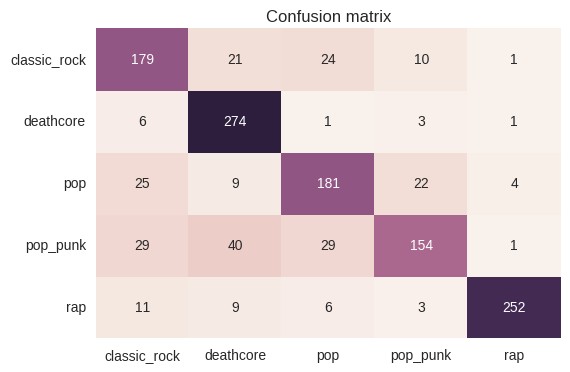

In [211]:
from sklearn.metrics import confusion_matrix

labels = le.inverse_transform(lr.classes_)

sns.heatmap(data=confusion_matrix(y_test, preds), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Ну и куда же без самых свойственных жанру слов по tf-idf:

In [231]:
genre_words = lambda x: ' '.join([word for song in x for word in song])

classic_rock_words = genre_words(df[df['genre'] == 'classic_rock']['lyrics'].values)
deathcore_words = genre_words(df[df['genre'] == 'deathcore']['lyrics'].values)
pop_words = genre_words(df[df['genre'] == 'pop']['lyrics'].values)
pop_punk_words = genre_words(df[df['genre'] == 'pop_punk']['lyrics'].values)
rap_words = genre_words(df[df['genre'] == 'rap']['lyrics'].values)

In [258]:
genres = [classic_rock_words, deathcore_words, pop_words, pop_punk_words, rap_words]
tfidf = TfidfVectorizer()
genres_tf = tfidf.fit_transform(genres)

In [508]:
feature_array = np.array(tfidf.get_feature_names())

for genre, tfs in zip(['classic_rock', 'deathcore', 'pop', 'pop_punk', 'rap'], genres_tf):
    tfidf_sorting = np.argsort(tfs.toarray()).flatten()[::-1]
    top_words = feature_array[tfidf_sorting][:26]
    top_nouns = []
    for word in top_words:
        if (pos_tag([word])[0][1].startswith('N')) & (word not in stopwords):
            top_nouns.append(word)
    print('Top words for %s: %s' % (genre, ', '.join(top_nouns)))

Top words for classic_rock: love, oh, baby, yeah, time, want, feel, way
Top words for deathcore: fuck, life, time, world, eye, feel, die, nothing
Top words for pop: love, oh, baby, yeah, want, cause, feel, girl, wanna
Top words for pop_punk: want, time, oh, cause, love, feel
Top words for rap: nigga, shit, aint, fuck, hook, bitch, cause, yeah, man, thats, ya, em


Интересно, что самой депрессивной песней оказалась небезызвестная Waif me (Rape me) из-за постоянного рефрена. Вот для таких случаев все-таки лучше учитывать что-то типа **valence**

In [394]:
df[df['gloom_ind'] == df['gloom_ind'].max()]

,artist,album,song,lyrics,genre,norm_lyrics,gloom_ind
6560,Nirvana,In Utero (1993) Nirvana,waif me,"[rape, rape, friend, rape, rape, im, one, im, ...",grunge,"[rape, rape, friend, rape, rape, im, one, im, ...",0.738095


Проверим выполнение закона Ципфа (т.к. тексты песен имеют несколько иную структуру, нежели обыные тексты, не помешает это сделать): 

In [317]:
total_words = genre_words(df['lyrics'])
cv = CountVectorizer()
indices = (cv.fit_transform([words])).toarray()[0]
args = np.argsort(indices).flatten()[::-1]

In [318]:
counts = indices[args]

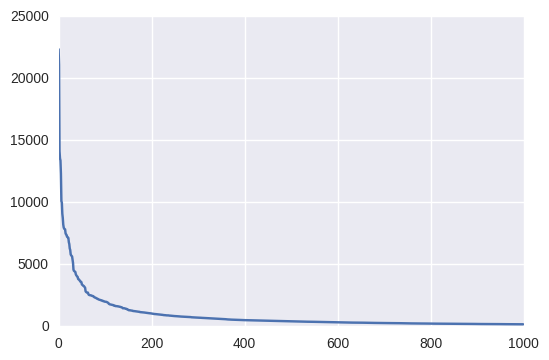

In [319]:
plt.plot(count[:1000])

Закон выполняется.

# Выводы

Я не могу сказать, что получилось какое-то уникальное по своим результатам исследование, однако было интересно посмотреть, насколько возможно измерять эмоциональный окрас музыкальных композиций при помощи компьютера. Результаты показали, что между жанрами действительно существует разница в этом плане. Еще получится довольно удивительный результат, что по тексту песни с точностью 80% предсказывался ее жанр.